In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import talib as ta
import datetime as dt
pd.set_option('display.max_rows', 16)

import statsmodels.api as sm

In [4]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

In [5]:
ta.__version__

'0.4.17'

# Data

In [6]:
START = '2007-01-01'
END = '2025-04-30'

In [7]:
index_info = DataAPI.SecIDGet(assetClass="IDX",pandas="1")

In [8]:
index_id = index_info[index_info['secShortName'].isin(['上证综指','深证综指','创业板指','沪深300','中证500','中证1000'])].drop_duplicates('secShortName').secID.values
index_df = DataAPI.MktIdxdGet(indexID=index_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','openIndex','closeIndex','turnoverVol','turnoverValue','CHGPct'],pandas="1")

In [9]:
index_df

,indexID,secShortName,tradeDate,openIndex,closeIndex,turnoverVol,turnoverValue,CHGPct
0,000001.ZICN,上证综指,2007-01-04,2728.1880,2715.7190,12015602100,8.394553e+10,0.015042
1,000001.ZICN,上证综指,2007-01-05,2668.5770,2641.3340,10615562500,7.012870e+10,-0.027391
2,000001.ZICN,上证综指,2007-01-08,2621.0680,2707.1990,10681324400,7.216588e+10,0.024936
3,000001.ZICN,上证综指,2007-01-09,2711.0490,2807.8040,11075126700,8.622197e+10,0.037162
4,000001.ZICN,上证综指,2007-01-10,2838.1130,2825.5760,11176936500,7.905066e+10,0.006330
5,000001.ZICN,上证综指,2007-01-11,2819.3670,2770.1100,12159871700,8.398673e+10,-0.019630
6,000001.ZICN,上证综指,2007-01-12,2745.3210,2668.1100,10730376800,7.343404e+10,-0.036822
7,000001.ZICN,上证综指,2007-01-15,2660.0700,2794.7010,9176156100,6.693948e+10,0.047446
...,...,...,...,...,...,...,...,...
25807,399106.ZICN,深证综指,2025-04-02,2010.2313,2014.5901,45905545136,5.628266e+11,0.001185


In [10]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']
# ST
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

In [11]:
# %%time
# # About 8 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y-%m-%d').year
# end_ = dt.datetime.strptime(START, '%Y-%m-%d').year+3
# field = ["secID","tradeDate",'preClosePrice',"closePrice",'openPrice',"negMarketValue","turnoverValue",'turnoverRate']
# while begin_ <= 2025:
#     if begin_ == 2025:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=field,pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=field,pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [12]:
# %%time
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   'preClosePrice',"closePrice",
#                                                   'openPrice','highestPrice','lowestPrice',
#                                                   "negMarketValue",
#                                                   "turnoverValue",'turnoverRate'],pandas="1")
# stk_df.to_pickle('./data/stk_df.pkl')
# Takes about 6 mins

In [13]:
stk_df = pd.read_pickle('./data/stk_df.pkl')

In [14]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13791161 entries, 0 to 13791160
Data columns (total 8 columns):
secID             object
tradeDate         object
preClosePrice     object
closePrice        object
openPrice         object
negMarketValue    object
turnoverValue     object
turnoverRate      object
dtypes: object(8)
memory usage: 841.7+ MB


In [15]:
num_cols = ['preClosePrice','closePrice','openPrice',
            'negMarketValue','turnoverValue','turnoverRate']

In [16]:
for col in num_cols:
    stk_df[col] = pd.to_numeric(stk_df[col])

In [17]:
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_df.shape)
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
stk_df = stk_df[stk_df['STflg'].isna()].copy()
stk_df.drop('STflg',axis=1,inplace=True)
print(stk_df.shape)

(13791161, 8)
(13206761, 8)


不填充停牌值比较合理，因为技术分析只看量价，直接计算量价关系较为合适

## 沪深300

In [18]:
hs300_df = index_df[index_df['secShortName']=='沪深300'].reset_index(drop=True)
hs300_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
hs300_df['open_ret'] = hs300_df['openIndex']/hs300_df['openIndex'].shift()-1
hs300_df

,indexID,secShortName,tradeDate,openIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret
0,000300.ZICN,沪深300,2007-01-04,2073.2500,2067.0900,10671970700,8.238107e+10,0.012758,NaN
1,000300.ZICN,沪深300,2007-01-05,2051.1500,2072.8800,9274344700,6.802606e+10,0.002801,-0.010660
2,000300.ZICN,沪深300,2007-01-08,2072.0000,2131.5600,8476790900,6.630394e+10,0.028308,0.010165
3,000300.ZICN,沪深300,2007-01-09,2137.4900,2200.0900,8157762900,6.545619e+10,0.032150,0.031607
4,000300.ZICN,沪深300,2007-01-10,2210.7600,2255.9700,8490497900,6.882262e+10,0.025399,0.034279
5,000300.ZICN,沪深300,2007-01-11,2257.0100,2231.6300,8627654800,6.873001e+10,-0.010789,0.020920
6,000300.ZICN,沪深300,2007-01-12,2215.8600,2173.7500,7652572000,6.174283e+10,-0.025936,-0.018232
7,000300.ZICN,沪深300,2007-01-15,2170.9400,2287.3400,6640309700,5.704345e+10,0.052255,-0.020272
...,...,...,...,...,...,...,...,...,...
4433,000300.ZICN,沪深300,2025-04-02,3884.4181,3884.3858,11304317500,1.982675e+11,-0.000848,-0.002148


In [19]:
hs300_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4441 entries, 0 to 4440
Data columns (total 9 columns):
indexID          4441 non-null object
secShortName     4441 non-null object
tradeDate        4441 non-null object
openIndex        4441 non-null float64
closeIndex       4441 non-null float64
turnoverVol      4441 non-null int64
turnoverValue    4441 non-null float64
close_ret        4441 non-null float64
open_ret         4440 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 312.3+ KB


In [20]:
# 过滤市场趋势
hs300_df['close_ret_demean'] = hs300_df['close_ret'] - hs300_df['close_ret'].mean()
hs300_df['open_ret_demean'] = hs300_df['open_ret'] - hs300_df['open_ret'].mean()

In [21]:
(hs300_df['close_ret']- hs300_df['close_ret_demean']).describe()

count    4.441000e+03
mean     2.711619e-04
std      2.439535e-18
min      2.711619e-04
25%      2.711619e-04
50%      2.711619e-04
75%      2.711619e-04
max      2.711619e-04
dtype: float64

In [22]:
hs300_cols = hs300_df.columns

# Technical indicators

## Moving average

### MA30

In [23]:
ta.SMA?

Docstring:
SMA(real[, timeperiod=?])

Simple Moving Average (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 30
Outputs:
    real
Type:      function


In [24]:
ta.SMA(hs300_df['closeIndex'], 5)

0              NaN
1              NaN
2              NaN
3              NaN
4       2145.51800
5       2178.42600
6       2198.60000
7       2229.75600
           ...    
4433    3901.39068
4434    3887.20902
4435    3822.06390
4436    3774.75458
4437    3734.57662
4438    3704.72248
4439    3682.52514
4440    3716.46546
Length: 4441, dtype: float64

In [25]:
hs300_df['closeIndex'].rolling(5).mean()

0              NaN
1              NaN
2              NaN
3              NaN
4       2145.51800
5       2178.42600
6       2198.60000
7       2229.75600
           ...    
4433    3901.39068
4434    3887.20902
4435    3822.06390
4436    3774.75458
4437    3734.57662
4438    3704.72248
4439    3682.52514
4440    3716.46546
Name: closeIndex, Length: 4441, dtype: float64

In [26]:
MA_df = hs300_df.copy()
MA_df['MA30'] = ta.SMA(MA_df['closeIndex'], 30)

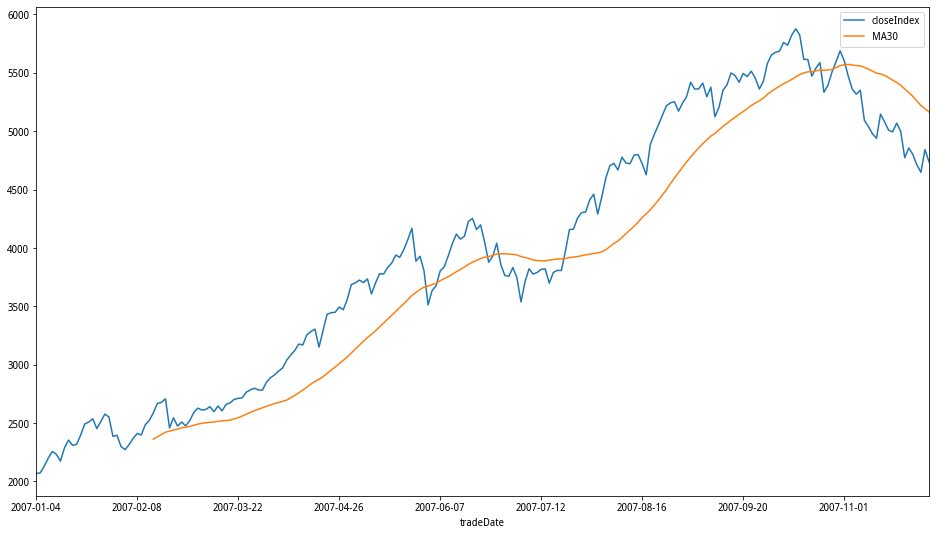

In [27]:
MA_df[['tradeDate','closeIndex','MA30']].set_index('tradeDate').loc[:'2007-12'].plot()

- 当收盘价高于均线时买入，低于均线时卖出

Case 1:
1. t日：收盘价高于MA30，假设可以以当日收盘价买入
2. t+k日：收盘价低于MA30，假设可以以当日收盘价卖出

Case 2:
1. t日：收盘价高于MA30，假设不能以当日收盘价买入。以次日开盘价买入
2. t+k日：收盘价低于MA30，假设不能以当日收盘价卖出。以次日开盘价卖出

In [28]:
MA_df['signal'] = np.nan
MA_df.loc[MA_df['closeIndex'] > MA_df['MA30'], 'signal'] = 1
MA_df.loc[MA_df['closeIndex'] < MA_df['MA30'], 'signal'] = 0

In [29]:
MA_df[~MA_df['signal'].isna()]

,indexID,secShortName,tradeDate,openIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,open_ret_demean,MA30,signal
29,000300.ZICN,沪深300,2007-02-14,2527.5600,2588.3500,6277727900,5.846227e+10,0.026052,0.011692,0.025781,0.011399,2362.236000,1.0
30,000300.ZICN,沪深300,2007-02-15,2607.6300,2668.6300,7163132900,6.741569e+10,0.031016,0.031679,0.030745,0.031386,2382.287333,1.0
31,000300.ZICN,沪深300,2007-02-16,2692.6700,2676.7400,7590878500,7.159758e+10,0.003039,0.032612,0.002768,0.032319,2402.416000,1.0
32,000300.ZICN,沪深300,2007-02-26,2679.2700,2707.6800,7453156000,7.098161e+10,0.011559,-0.004976,0.011288,-0.005269,2421.620000,1.0
33,000300.ZICN,沪深300,2007-02-27,2717.8100,2457.4900,10773680700,1.011028e+11,-0.092400,0.014385,-0.092671,0.014092,2430.200000,1.0
34,000300.ZICN,沪深300,2007-02-28,2413.4200,2544.5700,8282257100,7.714825e+10,0.035435,-0.111998,0.035164,-0.112291,2439.820000,1.0
35,000300.ZICN,沪深300,2007-03-01,2550.2600,2473.5400,8215965500,7.429958e+10,-0.027914,0.056700,-0.028185,0.056407,2447.883667,1.0
36,000300.ZICN,沪深300,2007-03-02,2468.6700,2508.7300,5794680500,5.422210e+10,0.014227,-0.031993,0.013956,-0.032286,2459.049667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4433,000300.ZICN,沪深300,2025-04-02,3884.4181,3884.3858,11304317500,1.982675e+11,-0.000848,-0.002148,-0.001119,-0.002441,3937.024473,0.0


In [30]:
MA_df['position_close'] = MA_df['signal'] # 第一天收盘价生成signal后，立即对应于第一天收盘价形成的头寸
MA_df['position_open'] = MA_df['signal'].shift() # 第一天用收盘价生成signal。对应于第二天的开盘价形成的头寸

In [31]:
# 再次滞后的原因：position变换的时候实现的收益
MA_df['position_close_ret'] = MA_df['position_close'].shift() * MA_df['close_ret']
MA_df['position_open_ret'] = MA_df['position_open'].shift() * MA_df['open_ret']
MA_df['position_close_ret_demean'] = MA_df['position_close'].shift() * MA_df['close_ret_demean']
MA_df['position_open_ret_demean'] = MA_df['position_open'].shift() * MA_df['open_ret_demean']

In [32]:
MA_df['MA30_close_cumret'] = (MA_df['position_close_ret']+1).cumprod()
MA_df['MA30_open_cumret'] = (MA_df['position_open_ret']+1).cumprod()

In [33]:
MA_df['signal'].unique()

array([nan,  1.,  0.])

In [34]:
MA_df[MA_df['signal']==0]

,indexID,secShortName,tradeDate,openIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,...,MA30,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,MA30_close_cumret,MA30_open_cumret
97,000300.ZICN,沪深300,2007-06-04,3804.9600,3511.4300,9053101900,1.312962e+11,-0.076899,-0.037474,-0.077170,...,3673.361667,0.0,0.0,1.0,-0.076899,-0.037474,-0.077170,-0.037767,1.356627,1.459164
98,000300.ZICN,沪深300,2007-06-05,3407.0000,3634.6300,11376803800,1.507649e+11,0.035085,-0.104590,0.034814,...,3685.062667,0.0,0.0,0.0,0.000000,-0.104590,0.000000,-0.104883,1.356627,1.306550
99,000300.ZICN,沪深300,2007-06-06,3652.8900,3677.5800,9595151000,1.359385e+11,0.011817,0.072172,0.011546,...,3697.498667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.356627,1.306550
112,000300.ZICN,沪深300,2007-06-25,4066.4500,3877.5900,7003104400,1.134327e+11,-0.042908,-0.032519,-0.043179,...,3925.166667,0.0,0.0,1.0,-0.042908,-0.032519,-0.043179,-0.032811,1.383489,1.392962
113,000300.ZICN,沪深300,2007-06-26,3804.4100,3928.2100,5888511400,8.786774e+10,0.013055,-0.064439,0.012784,...,3935.952333,0.0,0.0,0.0,0.000000,-0.064439,0.000000,-0.064732,1.383489,1.303200
115,000300.ZICN,沪深300,2007-06-28,4038.3800,3858.5200,6685798000,9.837205e+10,-0.045034,0.023183,-0.045305,...,3949.955667,0.0,0.0,1.0,-0.045034,0.000000,-0.045305,0.000000,1.321185,1.303200
116,000300.ZICN,沪深300,2007-06-29,3769.3300,3764.0800,5892087000,8.852759e+10,-0.024476,-0.066623,-0.024747,...,3949.537333,0.0,0.0,0.0,-0.000000,-0.066623,-0.000000,-0.066916,1.321185,1.216377
117,000300.ZICN,沪深300,2007-07-02,3746.1800,3757.6600,4974731000,7.199587e+10,-0.001706,-0.006142,-0.001977,...,3947.078000,0.0,0.0,0.0,-0.000000,-0.000000,-0.000000,-0.000000,1.321185,1.216377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4433,000300.ZICN,沪深300,2025-04-02,3884.4181,3884.3858,11304317500,1.982675e+11,-0.000848,-0.002148,-0.001119,...,3937.024473,0.0,0.0,0.0,-0.000000,-0.000000,-0.000000,-0.000000,4.276314,2.563749


In [35]:
MA_df.loc[96:99]

,indexID,secShortName,tradeDate,openIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,...,MA30,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,MA30_close_cumret,MA30_open_cumret
96,000300.ZICN,沪深300,2007-06-01,3953.10,3803.95,11993793900,1.939803e+11,-0.031569,0.032432,-0.031840,...,3664.847333,1.0,1.0,1.0,-0.031569,0.032432,-0.03184,0.032139,1.469641,1.515974
97,000300.ZICN,沪深300,2007-06-04,3804.96,3511.43,9053101900,1.312962e+11,-0.076899,-0.037474,-0.077170,...,3673.361667,0.0,0.0,1.0,-0.076899,-0.037474,-0.07717,-0.037767,1.356627,1.459164
98,000300.ZICN,沪深300,2007-06-05,3407.00,3634.63,11376803800,1.507649e+11,0.035085,-0.104590,0.034814,...,3685.062667,0.0,0.0,0.0,0.000000,-0.104590,0.00000,-0.104883,1.356627,1.306550
99,000300.ZICN,沪深300,2007-06-06,3652.89,3677.58,9595151000,1.359385e+11,0.011817,0.072172,0.011546,...,3697.498667,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,1.356627,1.306550


In [36]:
3511.43/3803.95 - 1

-0.07689901286820278

In [37]:
3407.00 / 3804.96 - 1

-0.10458979857869732

In [38]:
## Example
temp = MA_df.loc[99:113,['tradeDate','openIndex','closeIndex','close_ret','open_ret','signal','MA30',
                        'position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean']].copy()
temp['MA30_close_cumret'] = (temp['position_close_ret']+1).cumprod()
temp['MA30_open_cumret'] = (temp['position_open_ret']+1).cumprod()

display(temp)

# close 
print(3877.59 / 3802.30)

# open
print(3804.41 / 3814.19)

,tradeDate,openIndex,closeIndex,close_ret,open_ret,signal,MA30,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,MA30_close_cumret,MA30_open_cumret
99,2007-06-06,3652.89,3677.58,0.011817,0.072172,0.0,3697.498667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
100,2007-06-07,3694.55,3802.30,0.033914,0.011405,1.0,3719.232000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
101,2007-06-08,3814.19,3837.87,0.009355,0.032383,1.0,3737.518333,1.0,1.0,0.009355,0.000000,0.009084,0.000000,1.009355,1.000000
102,2007-06-11,3876.07,3931.86,0.024490,0.016224,1.0,3754.203000,1.0,1.0,0.024490,0.016224,0.024219,0.015931,1.034074,1.016224
103,2007-06-12,3953.96,4036.11,0.026514,0.020095,1.0,3773.900000,1.0,1.0,0.026514,0.020095,0.026243,0.019802,1.061492,1.036645
104,2007-06-13,4071.74,4118.27,0.020356,0.029788,1.0,3796.233000,1.0,1.0,0.020356,0.029788,0.020085,0.029495,1.083099,1.067524
105,2007-06-14,4103.52,4075.82,-0.010308,0.007805,1.0,3815.641000,1.0,1.0,-0.010308,0.007805,-0.010579,0.007512,1.071935,1.075856
106,2007-06-15,4043.11,4099.38,0.005780,-0.014722,1.0,3836.603000,1.0,1.0,0.005780,-0.014722,0.005509,-0.015014,1.078130,1.060018
107,2007-06-18,4178.76,4227.57,0.031271,0.033551,1.0,3858.898333,1.0,1.0,0.031271,0.033551,0.031000,0.033258,1.111845,1.095583
108,2007-06-19,4227.59,4253.00,0.006015,0.011685,1.0,3877.797333,1.0,1.0,0.006015,0.011685,0.005744,0.011393,1.118532,1.108385


1.0198011729742524
0.9974358907133625


In [39]:
MA30_ret_df = MA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','MA30',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean',
                        'MA30_close_cumret','MA30_open_cumret']].copy()

In [40]:
MA30_ret_df.set_index('tradeDate',inplace=True)

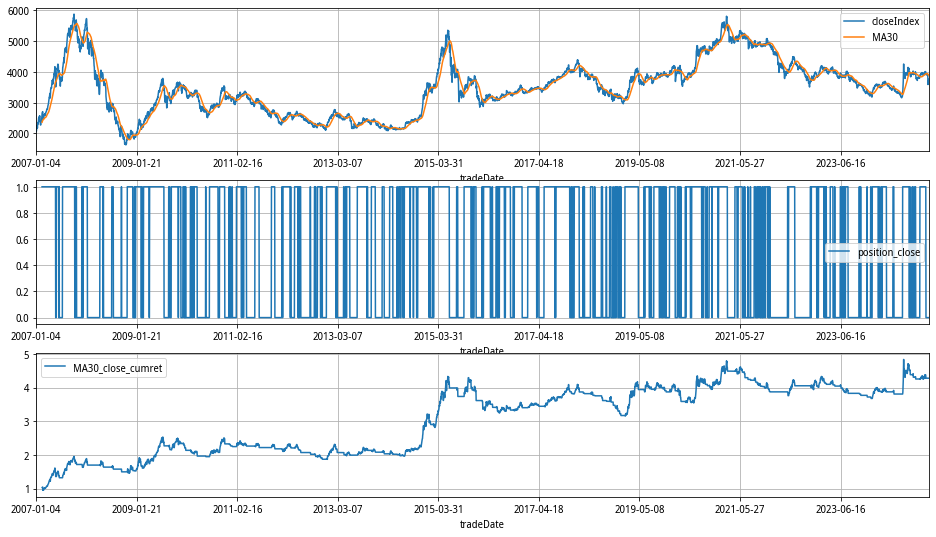

In [41]:
# Close price cumret
fig, axes = plt.subplots(3,1)
MA30_ret_df[['closeIndex','MA30']].plot(ax=axes[0],grid=True)
MA30_ret_df[['position_close']].plot(ax=axes[1],grid=True)
MA30_ret_df[['MA30_close_cumret']].plot(ax=axes[2],grid=True)

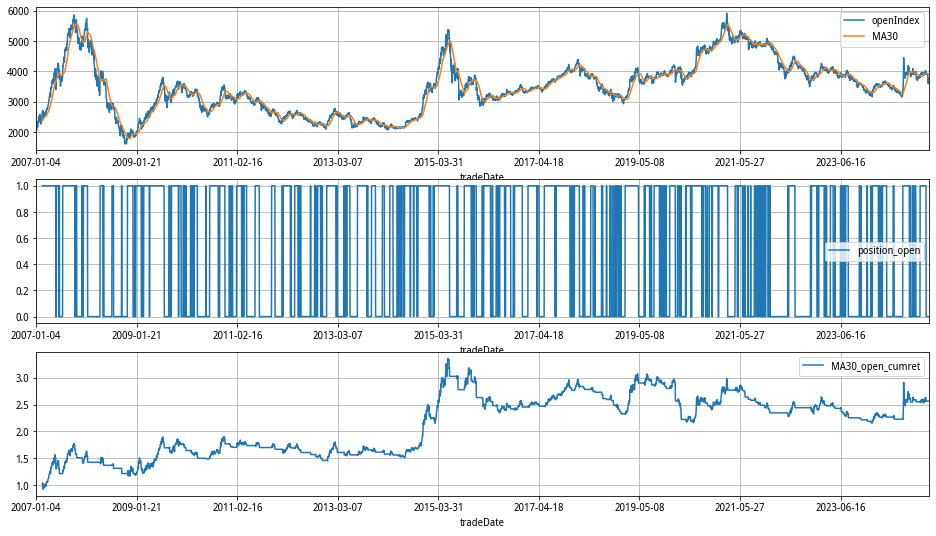

In [42]:
# open price cumret
fig, axes = plt.subplots(3,1)
MA30_ret_df[['openIndex','MA30']].plot(ax=axes[0],grid=True)
MA30_ret_df[['position_open']].plot(ax=axes[1], grid=True)
MA30_ret_df[['MA30_open_cumret']].plot(ax=axes[2], grid=True)

### MA20

In [43]:
hs300_df

,indexID,secShortName,tradeDate,openIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,open_ret_demean
0,000300.ZICN,沪深300,2007-01-04,2073.2500,2067.0900,10671970700,8.238107e+10,0.012758,NaN,0.012487,NaN
1,000300.ZICN,沪深300,2007-01-05,2051.1500,2072.8800,9274344700,6.802606e+10,0.002801,-0.010660,0.002530,-0.010952
2,000300.ZICN,沪深300,2007-01-08,2072.0000,2131.5600,8476790900,6.630394e+10,0.028308,0.010165,0.028037,0.009872
3,000300.ZICN,沪深300,2007-01-09,2137.4900,2200.0900,8157762900,6.545619e+10,0.032150,0.031607,0.031879,0.031314
4,000300.ZICN,沪深300,2007-01-10,2210.7600,2255.9700,8490497900,6.882262e+10,0.025399,0.034279,0.025128,0.033986
5,000300.ZICN,沪深300,2007-01-11,2257.0100,2231.6300,8627654800,6.873001e+10,-0.010789,0.020920,-0.011060,0.020628
6,000300.ZICN,沪深300,2007-01-12,2215.8600,2173.7500,7652572000,6.174283e+10,-0.025936,-0.018232,-0.026207,-0.018525
7,000300.ZICN,沪深300,2007-01-15,2170.9400,2287.3400,6640309700,5.704345e+10,0.052255,-0.020272,0.051984,-0.020565
...,...,...,...,...,...,...,...,...,...,...,...
4433,000300.ZICN,沪深300,2025-04-02,3884.4181,3884.3858,11304317500,1.982675e+11,-0.000848,-0.002148,-0.001119,-0.002441


In [44]:
MA_df = hs300_df.copy()

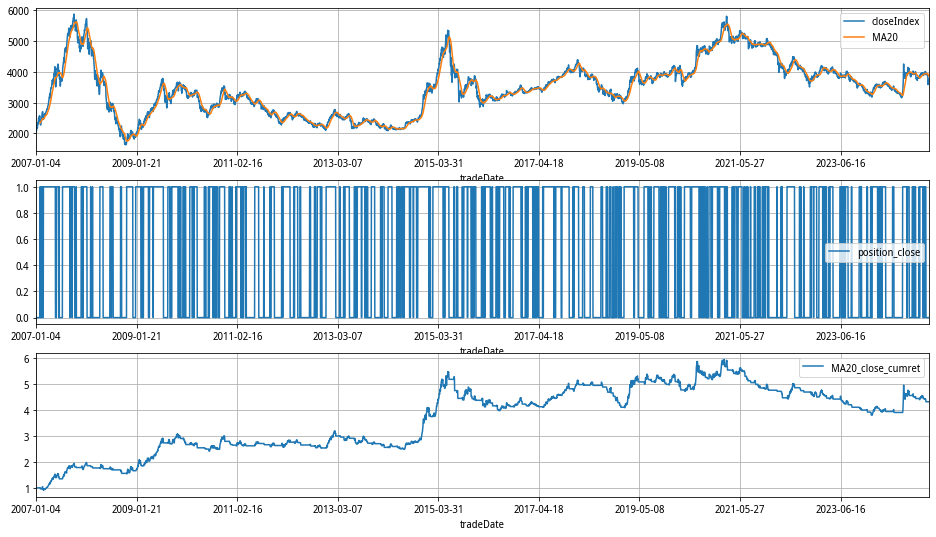

In [45]:
ma_length = 20

MA_df[f'MA{ma_length}'] = ta.SMA(MA_df['closeIndex'], ma_length)
MA_df['signal'] = 0
ndays = MA_df.shape[0]
MA_df.loc[MA_df['closeIndex'] > MA_df[f'MA{ma_length}'], 'signal'] = 1
MA_df['open_ret'] = MA_df['openIndex']/MA_df['openIndex'].shift()-1
MA_df['position_close'] = MA_df['signal']
MA_df['position_open'] = MA_df['signal'].shift()
MA_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
MA_df['position_close'] = MA_df['signal']
MA_df['position_close_ret'] = MA_df['position_close'].shift() * MA_df['close_ret']
MA_df['position_open_ret'] = MA_df['position_open'].shift() * MA_df['open_ret']
MA_df['position_close_ret_demean'] = MA_df['position_close'].shift() * MA_df['close_ret_demean']
MA_df['position_open_ret_demean'] = MA_df['position_open'].shift() * MA_df['open_ret_demean']

MA_df[f'MA{ma_length}_close_cumret'] = (MA_df['position_close_ret']+1).cumprod()
MA_df[f'MA{ma_length}_open_cumret'] = (MA_df['position_open_ret']+1).cumprod()
MA_ret_df = MA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret',f'MA{ma_length}',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean',
                        f'MA{ma_length}_close_cumret',f'MA{ma_length}_open_cumret']].copy()
MA_ret_df.set_index('tradeDate',inplace=True)
# Close price cumret
fig, axes = plt.subplots(3,1)
MA_ret_df[['closeIndex',f'MA{ma_length}']].plot(ax=axes[0],grid=True)
MA_ret_df[['position_close']].plot(ax=axes[1],grid=True)
MA_ret_df[[f'MA{ma_length}_close_cumret']].plot(ax=axes[2],grid=True)

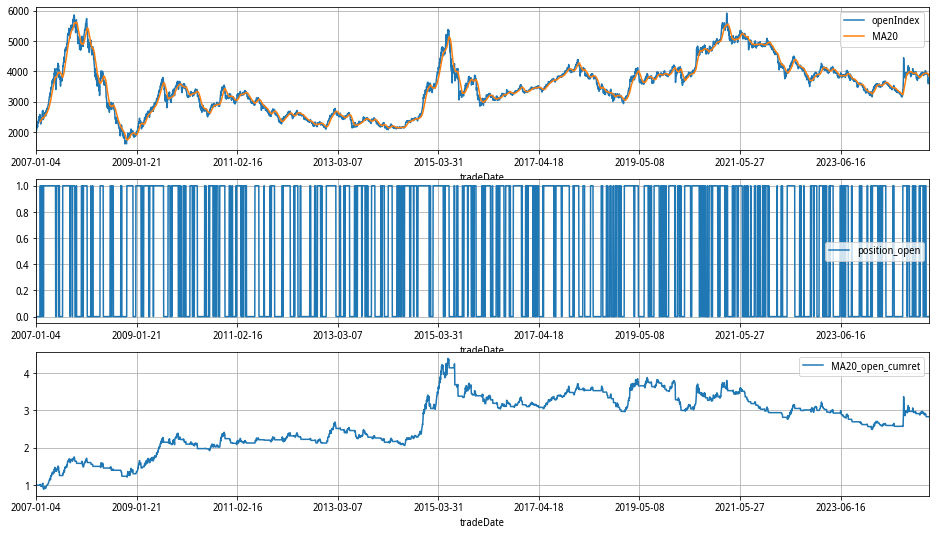

In [46]:
# open price cumret
fig, axes = plt.subplots(3,1)
MA_ret_df[['openIndex',f'MA{ma_length}']].plot(ax=axes[0],grid=True)
MA_ret_df[['position_open']].plot(ax=axes[1],grid=True)
MA_ret_df[[f'MA{ma_length}_open_cumret']].plot(ax=axes[2],grid=True)

## Exponential moving average

In [47]:
ta.EMA?

Docstring:
EMA(real[, timeperiod=?])

Exponential Moving Average (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 30
Outputs:
    real
Type:      function


\begin{aligned}
E M A_{\text {Today }}=&\left(\text { Value }_{\text {Today }} *\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right) \\
&+E M A_{\text {Yesterday }} *\left(1-\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right)
\end{aligned}

Smoothing = 2

### EMA20

In [48]:
ema_length = 20
EMA_df = hs300_df.copy()
EMA_df['EMA'] = ta.EMA(EMA_df['closeIndex'], ema_length)

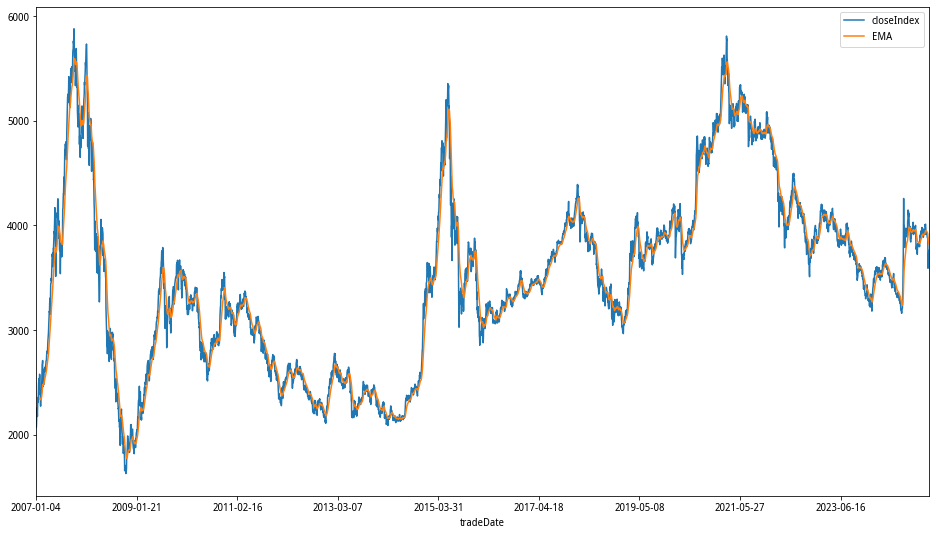

In [49]:
EMA_df[['tradeDate','closeIndex','EMA']].set_index('tradeDate').plot()

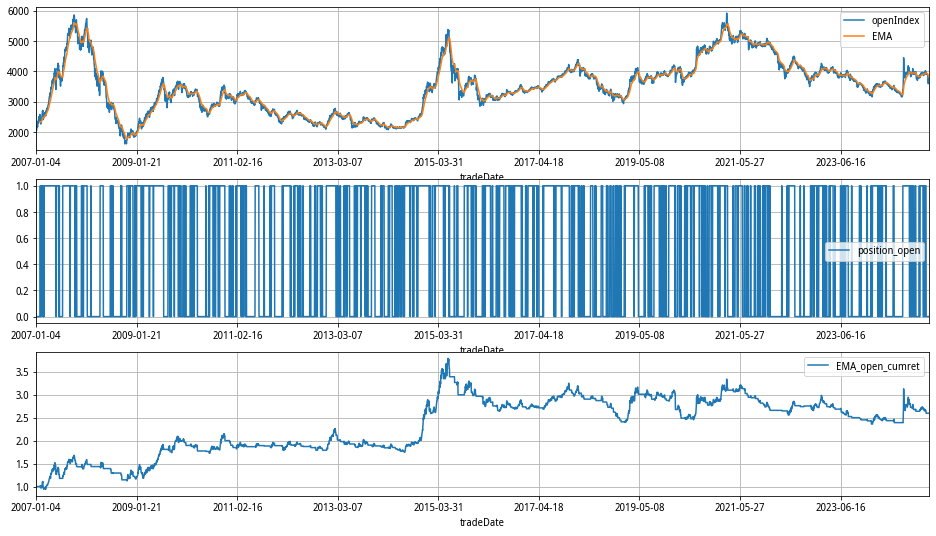

In [50]:
EMA_df['EMA'] = ta.EMA(EMA_df['closeIndex'], ema_length)
EMA_df['signal'] = 0
EMA_df.loc[EMA_df['closeIndex'] > EMA_df['EMA'], 'signal'] = 1
EMA_df['open_ret'] = EMA_df['openIndex']/EMA_df['openIndex'].shift()-1
EMA_df['position_close'] = EMA_df['signal']
EMA_df['position_open'] = EMA_df['signal'].shift()
EMA_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
EMA_df['position_close_ret'] = EMA_df['position_close'].shift() * EMA_df['close_ret']
EMA_df['position_open_ret'] = EMA_df['position_open'].shift() * EMA_df['open_ret']
EMA_df['position_close_ret_demean'] = EMA_df['position_close'].shift() * EMA_df['close_ret_demean']
EMA_df['position_open_ret_demean'] = EMA_df['position_open'].shift() * EMA_df['open_ret_demean']
EMA_df['EMA_close_cumret'] = (EMA_df['position_close_ret']+1).cumprod()
EMA_df['EMA_open_cumret'] = (EMA_df['position_open_ret']+1).cumprod()
EMA_ret_df = EMA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','EMA',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                       'position_close_ret_demean','position_open_ret_demean',
                        'EMA_close_cumret','EMA_open_cumret']].copy()
EMA_ret_df.set_index('tradeDate',inplace=True)
# open price cumret
fig, axes = plt.subplots(3,1)
EMA_ret_df[['openIndex','EMA']].plot(ax=axes[0], grid=True)
EMA_ret_df[['position_open']].plot(ax=axes[1], grid=True)
EMA_ret_df[['EMA_open_cumret']].plot(ax=axes[2], grid=True)

In [51]:
EMA_ret_df

,openIndex,closeIndex,open_ret,close_ret,EMA,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,EMA_close_cumret,EMA_open_cumret
tradeDate,,,,,,,,,,,,,,
2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,NaN,0,0,0.0,0.0,NaN,0.0,NaN,1.000000,NaN
2007-01-08,2072.0000,2131.5600,0.010165,0.028308,NaN,0,0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
2007-01-09,2137.4900,2200.0900,0.031607,0.032150,NaN,0,0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
2007-01-10,2210.7600,2255.9700,0.034279,0.025399,NaN,0,0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,NaN,0,0,0.0,-0.0,0.0,-0.0,0.0,1.000000,1.000000
2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,NaN,0,0,0.0,-0.0,-0.0,-0.0,-0.0,1.000000,1.000000
2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,NaN,0,0,0.0,0.0,-0.0,0.0,-0.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Statistical Inferences

## Cross-sectional test

In [52]:
def rule_return(df, demean=True, open_ret=True):
    """
    df should contain these columns:
        signal: the signal generated by the rule
        close_ret: return calculated by close price
        open_ret: return calculated by open price
    close_ret_demean is demeaned return of close_ret, i.e. close_ret - close_ret.mean.
    open_ret_demean is similarly defined. The use of demeaned return series is to adjust the
    bias created by bullish or bearish markets.
    """
    df['close_ret_demean'] = df['close_ret'] - df['close_ret'].mean()
    df['open_ret_demean'] = df['open_ret'] - df['open_ret'].mean()
    df['position_close'] = df['signal']
    df['position_open'] = df['signal'].shift()
    df['position_close_ret'] = df['position_close'].shift() * df['close_ret']
    df['position_open_ret'] = df['position_open'].shift() * df['open_ret']
    df['position_close_ret_demean'] = df['position_close'].shift() * df['close_ret_demean']
    df['position_open_ret_demean'] = df['position_open'].shift() * df['open_ret_demean']
    df['close_cumret'] = (df['position_close_ret']+1).cumprod()
    df['open_cumret'] = (df['position_open_ret']+1).cumprod()
    if open_ret:
        if demean:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_open_ret_demean':df['position_open_ret_demean'].values, 
                                 'open_cumret':df['open_cumret'].values})
        else:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_open_ret':df['position_open_ret'].values, 
                                 'open_cumret':df['open_cumret'].values})
    else:
        if demean:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_close_ret_demean':df['position_close_ret_demean'].values, 
                                 'close_cumret':df['close_cumret'].values})
        else:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_close_ret':df['position_close_ret'].values, 
                                 'close_cumret':df['close_cumret'].values})

In [53]:
ema_length = 20

In [54]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,negMarketValue,turnoverValue,turnoverRate
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,4.835036e+10,4.182345e+09,0.0840
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,5.318694e+10,2.285485e+09,0.0440
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,5.487665e+10,2.761567e+09,0.0510
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,5.456661e+10,2.324186e+09,0.0426
113,000001.XSHE,2007-06-26,1113.904,1113.904,0.000,5.456661e+10,0.000000e+00,0.0000
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,4.994705e+10,2.446556e+09,0.0489
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,4.672266e+10,1.617434e+09,0.0336
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,4.266117e+10,1.410758e+09,0.0316
...,...,...,...,...,...,...,...,...
13791153,689009.XSHG,2025-04-02,64.411,64.149,64.330,3.502029e+10,2.618055e+08,0.0075


In [55]:
stk_df['EMA'] = stk_df.groupby('secID')['closePrice'].apply(ta.EMA, 20)

In [56]:
stk_df.drop(stk_df.loc[stk_df['openPrice']==0].index, inplace=True) # drop 停牌但有收盘价的数据

In [57]:
stk_df.loc[stk_df['openPrice']==0]

,secID,tradeDate,preClosePrice,closePrice,openPrice,negMarketValue,turnoverValue,turnoverRate,EMA


In [58]:
stk_df['open_ret'] = stk_df.groupby('secID')['openPrice'].apply(lambda x: x / x.shift() - 1)

In [59]:
stk_df['close_ret'] = stk_df['closePrice']/stk_df['preClosePrice'] - 1


In [60]:
stk_df['signal'] = 0
stk_df.loc[stk_df['closePrice'] > stk_df['EMA'], 'signal'] = 1

In [61]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,negMarketValue,turnoverValue,turnoverRate,EMA,open_ret,close_ret,signal
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,4.835036e+10,4.182345e+09,0.0840,NaN,NaN,0.197544,0
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,5.318694e+10,2.285485e+09,0.0440,NaN,-0.016970,0.100033,0
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,5.487665e+10,2.761567e+09,0.0510,NaN,0.097410,0.031769,0
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,5.456661e+10,2.324186e+09,0.0426,NaN,0.011516,-0.005650,0
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,4.994705e+10,2.446556e+09,0.0489,NaN,-0.120245,-0.084659,0
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,4.672266e+10,1.617434e+09,0.0336,NaN,-0.005682,-0.064557,0
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,4.266117e+10,1.410758e+09,0.0316,NaN,-0.053968,-0.086928,0
117,000001.XSHE,2007-07-02,870.870,867.073,848.402,4.247515e+10,8.756147e+08,0.0209,NaN,-0.100336,-0.004360,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13791153,689009.XSHG,2025-04-02,64.411,64.149,64.330,3.502029e+10,2.618055e+08,0.0075,62.681283,-0.021150,-0.004068,1


In [62]:
%%time
rule_ret_df = stk_df.groupby('secID').apply(rule_return)

CPU times: user 58 s, sys: 1.36 s, total: 59.4 s
Wall time: 59.4 s


In [63]:
rule_ret_df.reset_index(inplace=True)

In [64]:
rule_ret_df.drop('level_1',axis=1,inplace=True)

In [65]:
rule_ret_df

,secID,tradeDate,position_open_ret_demean,open_cumret
0,000001.XSHE,2007-06-20,NaN,NaN
1,000001.XSHE,2007-06-21,NaN,NaN
2,000001.XSHE,2007-06-22,0.000000,1.000000
3,000001.XSHE,2007-06-25,0.000000,1.000000
4,000001.XSHE,2007-06-27,-0.000000,1.000000
5,000001.XSHE,2007-06-28,-0.000000,1.000000
6,000001.XSHE,2007-06-29,-0.000000,1.000000
7,000001.XSHE,2007-07-02,-0.000000,1.000000
...,...,...,...,...
12825314,689009.XSHG,2025-04-02,-0.022381,0.839274


### Cross-sectional test of cumulative return

In [66]:
rule_cumret_by_crs = rule_ret_df.groupby('secID')['open_cumret'].last()

In [67]:
rule_cumret_by_crs.describe()

count    5377.000000
mean        2.106883
std         3.666502
min         0.020755
25%         0.619295
50%         1.003313
75%         2.104380
max        65.822967
Name: open_cumret, dtype: float64

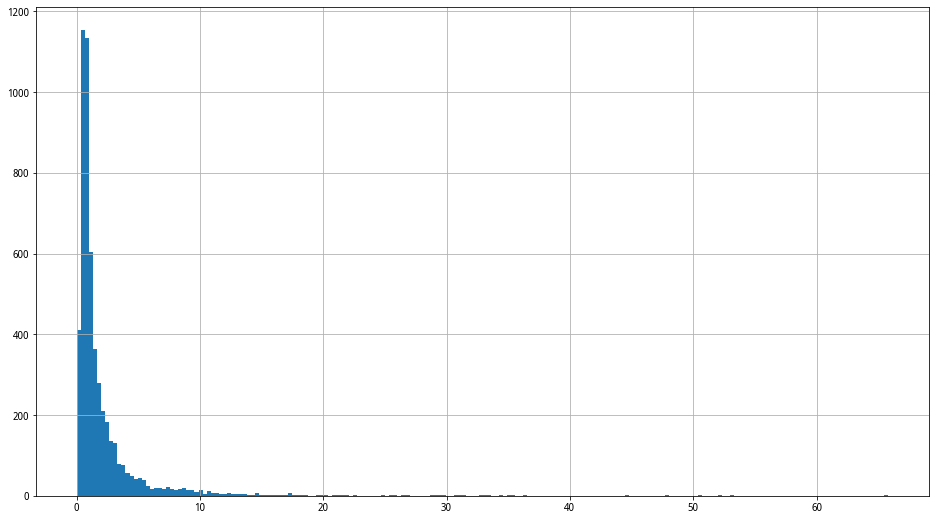

In [68]:
rule_cumret_by_crs.hist(bins=200)

In [69]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y-const, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_cumret'])

,rule_cumret
ret_mean,1.106883
t_values,22.139107


In [70]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit()
print(reg.t_test('const = 1'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             2.1069      0.050     22.137      0.000       2.009       2.205


平均年化收益：

In [71]:
# # 1.12/(2022-2007+1)
# 2.12**(1/(2022-2007+1)) - 1

In [72]:
2.1069**(1/(2024-2007+1)) - 1

0.04226995307322956

这个统计检验不够好：
- 累积收益率可能在区间最后一段短时间内冲高
- 累积收益率右侧可以无限大，左侧有界(0)。日收益率原则上也是这样，但没有累积收益率这么严重

In [73]:
rule_ret_df.loc[rule_ret_df['tradeDate']>='2018-01-01']

,secID,tradeDate,position_open_ret_demean,open_cumret
2480,000001.XSHE,2018-01-02,0.000000,1.869044
2481,000001.XSHE,2018-01-03,0.028072,1.922245
2482,000001.XSHE,2018-01-04,-0.030253,1.864844
2483,000001.XSHE,2018-01-05,-0.008650,1.849444
2484,000001.XSHE,2018-01-08,0.000000,1.849444
2485,000001.XSHE,2018-01-09,-0.022278,1.808966
2486,000001.XSHE,2018-01-10,0.000000,1.808966
2487,000001.XSHE,2018-01-11,0.000000,1.808966
...,...,...,...,...
12825314,689009.XSHG,2025-04-02,-0.022381,0.839274


In [74]:
rule_cumret_by_crs = rule_ret_df.loc[rule_ret_df['tradeDate']>='2022-01-01'].groupby('secID')['open_cumret'].last()
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y-const, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_cumret'])

,rule_cumret
ret_mean,1.082215
t_values,21.354258


### Cross-sectional test of mean daily return

In [75]:
# time-series mean of daily return
rule_tsmean_ret_by_crs = rule_ret_df.groupby('secID')['position_open_ret_demean'].mean()
rule_tsmean_ret_by_crs

secID
000001.XSHE    0.000115
000002.XSHE    0.000070
000004.XSHE   -0.000122
000005.XSHE    0.000357
000006.XSHE    0.000312
000007.XSHE    0.000319
000008.XSHE    0.000367
000009.XSHE    0.000307
                 ...   
688789.XSHG   -0.001230
688793.XSHG   -0.001176
688798.XSHG    0.000209
688799.XSHG   -0.000163
688800.XSHG    0.000135
688819.XSHG    0.000506
688981.XSHG    0.000124
689009.XSHG   -0.000575
Name: position_open_ret_demean, Length: 5378, dtype: float64

In [76]:
temp = stk_df[stk_df['secID']==np.random.choice(stk_df['secID'].unique(),1)[0]].copy()
temp['signal'] = 0
temp.loc[temp['closePrice'] > temp['EMA'], 'signal'] = 1
display(temp)
rule_return(temp)['position_open_ret_demean'].mean()

,secID,tradeDate,preClosePrice,closePrice,openPrice,negMarketValue,turnoverValue,turnoverRate,EMA,open_ret,close_ret,signal
13790080,689009.XSHG,2020-10-29,18.940,38.500,33.000,2.220064e+09,1.584101e+09,0.7102,NaN,NaN,1.032735,0
13790081,689009.XSHG,2020-10-30,38.500,47.600,40.020,2.744806e+09,1.515931e+09,0.5827,NaN,0.212727,0.236364,0
13790082,689009.XSHG,2020-11-02,47.600,56.770,50.200,3.273585e+09,1.428223e+09,0.4716,NaN,0.254373,0.192647,0
13790083,689009.XSHG,2020-11-03,56.770,57.390,56.500,3.309337e+09,1.409432e+09,0.4357,NaN,0.125498,0.010921,0
13790084,689009.XSHG,2020-11-04,57.390,54.400,57.450,3.136922e+09,1.138491e+09,0.3615,NaN,0.016814,-0.052100,0
13790085,689009.XSHG,2020-11-05,54.400,61.000,55.950,3.517504e+09,1.764147e+09,0.5002,NaN,-0.026110,0.121324,0
13790086,689009.XSHG,2020-11-06,61.000,68.600,59.800,3.955750e+09,1.462900e+09,0.4017,NaN,0.068811,0.124590,0
13790087,689009.XSHG,2020-11-09,68.600,68.040,70.500,3.923459e+09,1.517928e+09,0.3901,NaN,0.178930,-0.008163,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13791153,689009.XSHG,2025-04-02,64.411,64.149,64.330,3.502029e+10,2.618055e+08,0.0075,62.681283,-0.021150,-0.004068,1


-0.0005752684542024469

In [77]:
rule_tsmean_ret_by_crs['002976.XSHE']

-0.0008931209962963127

In [78]:
rule_tsmean_ret_by_crs.dropna(inplace=True)
y = rule_tsmean_ret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]

In [79]:
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_daily_ret'])

,rule_daily_ret
ret_mean,-0.000034
t_values,-4.803218


## Time series test. Bootstrapping: White's Reality Check

- 原始index return去掉均值的目的：过滤掉牛市或者熊市时，随机策略的正或负的收益的偏误
- position return 去掉均值的目的：bootstrap 的原假设是：策略期望收益是0。以此生成抽样分布。

In [80]:
EMA_ret_df

,openIndex,closeIndex,open_ret,close_ret,EMA,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,EMA_close_cumret,EMA_open_cumret
tradeDate,,,,,,,,,,,,,,
2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,NaN,0,0,0.0,0.0,NaN,0.0,NaN,1.000000,NaN
2007-01-08,2072.0000,2131.5600,0.010165,0.028308,NaN,0,0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
2007-01-09,2137.4900,2200.0900,0.031607,0.032150,NaN,0,0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
2007-01-10,2210.7600,2255.9700,0.034279,0.025399,NaN,0,0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,NaN,0,0,0.0,-0.0,0.0,-0.0,0.0,1.000000,1.000000
2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,NaN,0,0,0.0,-0.0,-0.0,-0.0,-0.0,1.000000,1.000000
2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,NaN,0,0,0.0,0.0,-0.0,0.0,-0.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [81]:
rule_ret_series = EMA_ret_df['position_open_ret_demean'].dropna() # position_open_ret_demean: (raw return demeaned)*position
rule_ret_series_for_bootstrap = rule_ret_series - rule_ret_series.mean() # demean here: H0: the average of the rule's return is zero
n_sample = rule_ret_series.shape[0]
n_boostrap = 1000

In [82]:
n_sample

4439

In [83]:
rule_ret_series.mean()

0.00013381099113589853

In [84]:
rule_ret_mean_distr = []
for i in range(n_boostrap):
    rule_ret_mean_distr.append(np.random.choice(rule_ret_series_for_bootstrap, n_sample).mean())

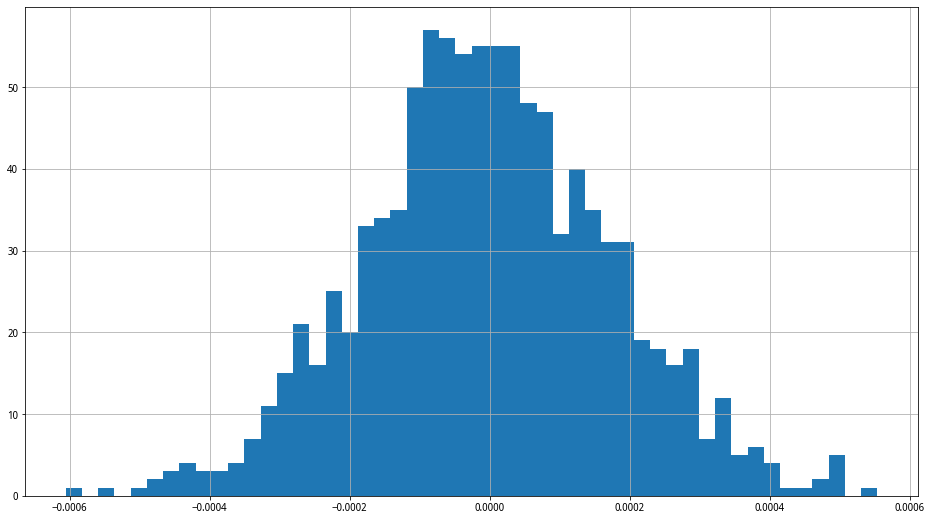

In [85]:
rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
rule_ret_mean_distr.hist(bins=50)

In [86]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum()

215

In [87]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum() / n_boostrap

0.215

In [88]:
np.mean(rule_ret_series)

0.00013381099113589853

In [89]:
def white_reality_test(rule_ret, n_boostrap=1000):
    n_sample = len(rule_ret)
    if n_sample < 100:
        return None
    else:
        mean_rule_ret = np.mean(rule_ret)
        rule_ret_for_bootstrap = rule_ret - mean_rule_ret
        rule_ret_mean_distr = []
        for i in range(n_boostrap):
            rule_ret_mean_distr.append(np.random.choice(rule_ret_for_bootstrap, n_sample).mean())
        rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
        pvalue = (rule_ret_mean_distr > mean_rule_ret).sum() / n_boostrap
        return pvalue

In [90]:
# The p value of the rule's return series
white_reality_test(rule_ret_series)

0.222

#### Test another stock

In [91]:
one_stk_id = np.random.choice(rule_ret_df['secID'].unique(),1)[0]

In [92]:
rule_ret_series = rule_ret_df.loc[rule_ret_df['secID'] == one_stk_id,'position_open_ret_demean']

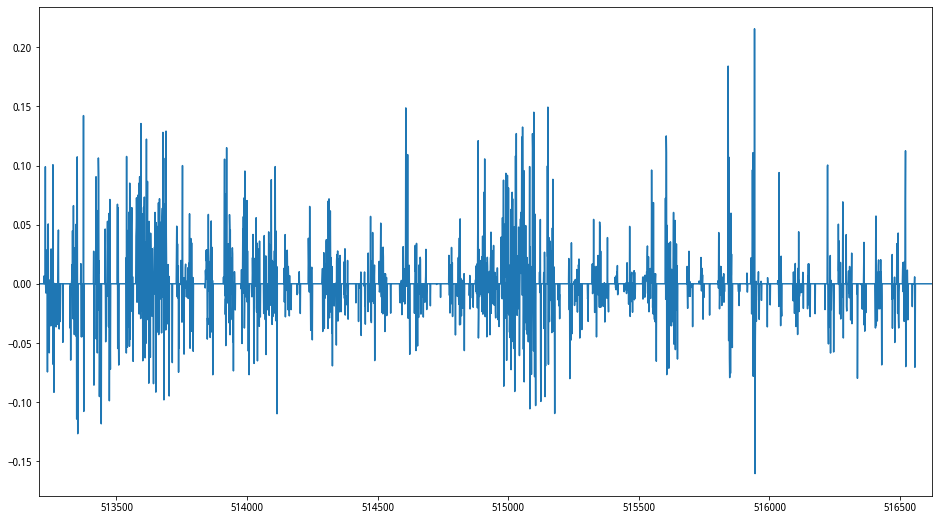

In [93]:
rule_ret_series.plot()

In [94]:
rule_ret_series.dropna(inplace=True)

In [95]:
white_reality_test(rule_ret_series)

0.114

#### Test 300 stocks

In [96]:
stk_id_300 = np.random.choice(rule_ret_df['secID'].unique(),300,replace=False)

In [97]:
temp = rule_ret_df.loc[rule_ret_df['secID'].isin(stk_id_300)].copy()

In [98]:
temp.dropna(inplace=True)

In [99]:
temp

,secID,tradeDate,position_open_ret_demean,open_cumret
2,000001.XSHE,2007-06-22,0.0,1.000000
3,000001.XSHE,2007-06-25,0.0,1.000000
4,000001.XSHE,2007-06-27,-0.0,1.000000
5,000001.XSHE,2007-06-28,-0.0,1.000000
6,000001.XSHE,2007-06-29,-0.0,1.000000
7,000001.XSHE,2007-07-02,-0.0,1.000000
8,000001.XSHE,2007-07-03,0.0,1.000000
9,000001.XSHE,2007-07-04,-0.0,1.000000
...,...,...,...,...
12822058,688800.XSHG,2025-04-02,-0.0,1.025793


In [100]:
%%time
stk_white_p = temp.groupby('secID')['position_open_ret_demean'].apply(white_reality_test)

CPU times: user 46.6 s, sys: 0 ns, total: 46.6 s
Wall time: 46.6 s


In [101]:
stk_white_p

secID
000001.XSHE    0.314
000018.XSHE    0.068
000034.XSHE    0.621
000039.XSHE    0.276
000410.XSHE    0.404
000417.XSHE    0.490
000422.XSHE    0.398
000505.XSHE    0.554
               ...  
688553.XSHG    0.278
688555.XSHG    0.745
688566.XSHG    0.663
688621.XSHG    0.270
688689.XSHG    0.447
688697.XSHG    0.162
688787.XSHG    0.250
688800.XSHG    0.450
Name: position_open_ret_demean, Length: 300, dtype: float64

In [102]:
stk_white_p.describe()

count    297.000000
mean       0.481976
std        0.241701
min        0.005000
25%        0.291000
50%        0.477000
75%        0.664000
max        0.984000
Name: position_open_ret_demean, dtype: float64

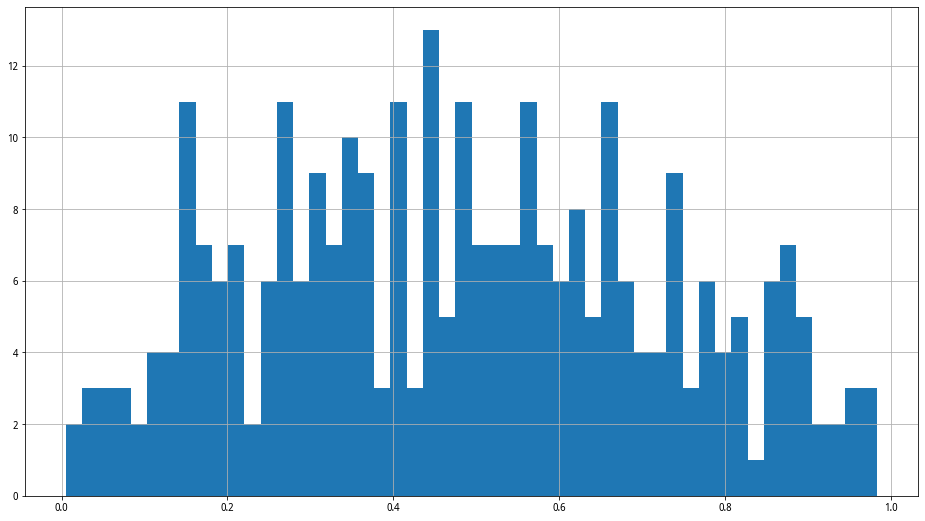

In [103]:
stk_white_p.hist(bins=50)

In [104]:
stk_white_p.loc[stk_white_p < 0.10]

secID
000018.XSHE    0.068
000576.XSHE    0.030
001696.XSHE    0.052
002164.XSHE    0.081
002167.XSHE    0.076
300268.XSHE    0.087
600223.XSHG    0.086
600606.XSHG    0.029
600634.XSHG    0.005
600654.XSHG    0.022
600677.XSHG    0.059
600839.XSHG    0.056
688068.XSHG    0.036
Name: position_open_ret_demean, dtype: float64

In [105]:
good_EMA_stks = stk_white_p.loc[stk_white_p < 0.10].index

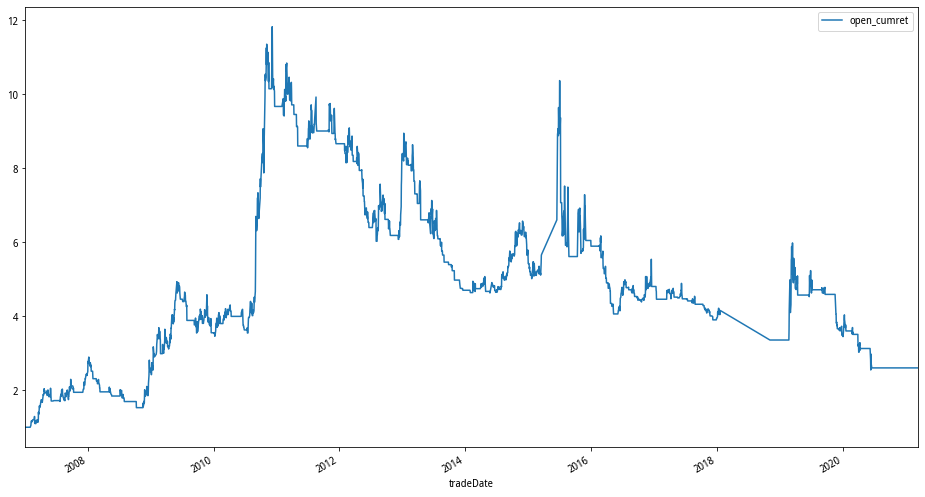

In [106]:
rule_ret_df.loc[rule_ret_df['secID']=='600086.XSHG',['tradeDate','open_cumret']].set_index('tradeDate').plot()

In [107]:
rule_ret_df.loc[rule_ret_df['secID'].isin(good_EMA_stks[0:5])].set_index('tradeDate',inplace=True)

In [108]:
temp2 = rule_ret_df.loc[rule_ret_df['secID'].isin(good_EMA_stks)].copy()

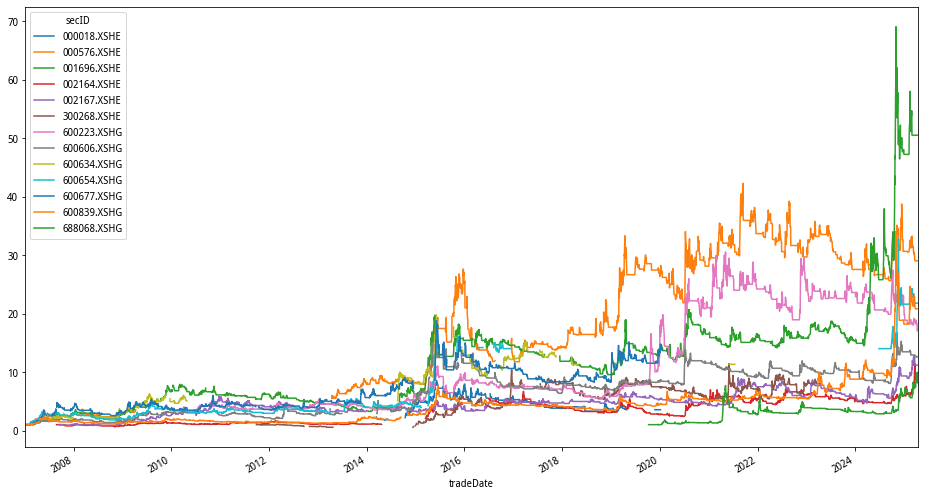

In [109]:
temp2.pivot(index='tradeDate',columns='secID',values='open_cumret').plot()

# MACD

Moving Average Convergence Divergence (MACD)

$$MACD = EMA_{\text{fast period}} - EMA_{\text{slow period}}$$ （也叫DIF）

$$E M A_t(\text{Value})= \left(\text { Value }_t *\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right) + E M A_{t-1} *\left(1-\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right)$$

$Smoothing = 2$, $\text{fast period} = 12$, $\text{slow period} = 26$. 第一个$EMA$用简单平均。比如，计算$EMA_{\text{12 period}}$，那么就等有12个观测值之后，取简单平均得到$EMA_1$，然后$EMA_2$用上述公式计算。

按照级数展开可发现，越靠近当前的价格，权重越大。Smoothing越大，越靠近当前价格的权重越大。

得到 MACD 以后，再计算 MACD 的 Signal (也叫DEA)，

$$Signal = EMA_{\text{9 period}}(MACD) $$

判断标准：当 MACD 上穿 Signal 时，处于上升趋势。当 MACD 下穿 Signal 时，处于下降趋势。

MACD 的核心逻辑是：

趋势反转时，短期均线（如12日EMA）会比长期均线（如26日EMA）更快地反应价格变化；

（MACD）DIF 上穿（Signal） DEA（“金叉”）被视为买入信号；

（MACD）DIF 下穿（Signal）DEA（“死叉”）被视为卖出信号；

In [110]:
MACD_df = hs300_df.copy()

In [111]:
fastperiod = 12  
slowperiod = 26  
signalperiod = 9 

In [112]:
MACD_df

,indexID,secShortName,tradeDate,openIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,open_ret_demean
0,000300.ZICN,沪深300,2007-01-04,2073.2500,2067.0900,10671970700,8.238107e+10,0.012758,NaN,0.012487,NaN
1,000300.ZICN,沪深300,2007-01-05,2051.1500,2072.8800,9274344700,6.802606e+10,0.002801,-0.010660,0.002530,-0.010952
2,000300.ZICN,沪深300,2007-01-08,2072.0000,2131.5600,8476790900,6.630394e+10,0.028308,0.010165,0.028037,0.009872
3,000300.ZICN,沪深300,2007-01-09,2137.4900,2200.0900,8157762900,6.545619e+10,0.032150,0.031607,0.031879,0.031314
4,000300.ZICN,沪深300,2007-01-10,2210.7600,2255.9700,8490497900,6.882262e+10,0.025399,0.034279,0.025128,0.033986
5,000300.ZICN,沪深300,2007-01-11,2257.0100,2231.6300,8627654800,6.873001e+10,-0.010789,0.020920,-0.011060,0.020628
6,000300.ZICN,沪深300,2007-01-12,2215.8600,2173.7500,7652572000,6.174283e+10,-0.025936,-0.018232,-0.026207,-0.018525
7,000300.ZICN,沪深300,2007-01-15,2170.9400,2287.3400,6640309700,5.704345e+10,0.052255,-0.020272,0.051984,-0.020565
...,...,...,...,...,...,...,...,...,...,...,...
4433,000300.ZICN,沪深300,2025-04-02,3884.4181,3884.3858,11304317500,1.982675e+11,-0.000848,-0.002148,-0.001119,-0.002441


In [113]:
MACD_df['MACD'], MACD_df['MACD_signal'], _ = ta.MACD(MACD_df['closeIndex'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)

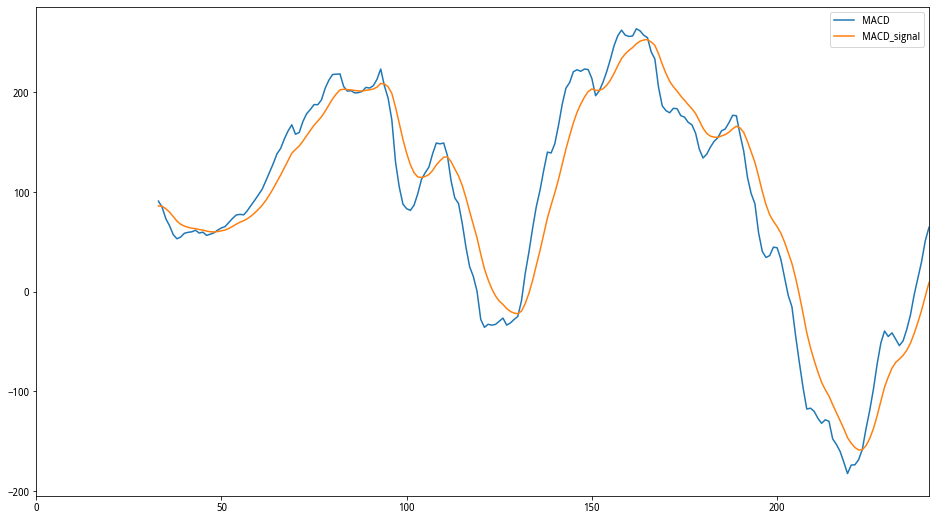

In [114]:
MACD_df.loc[MACD_df['tradeDate']<='2007-12-31',['MACD','MACD_signal']].plot()

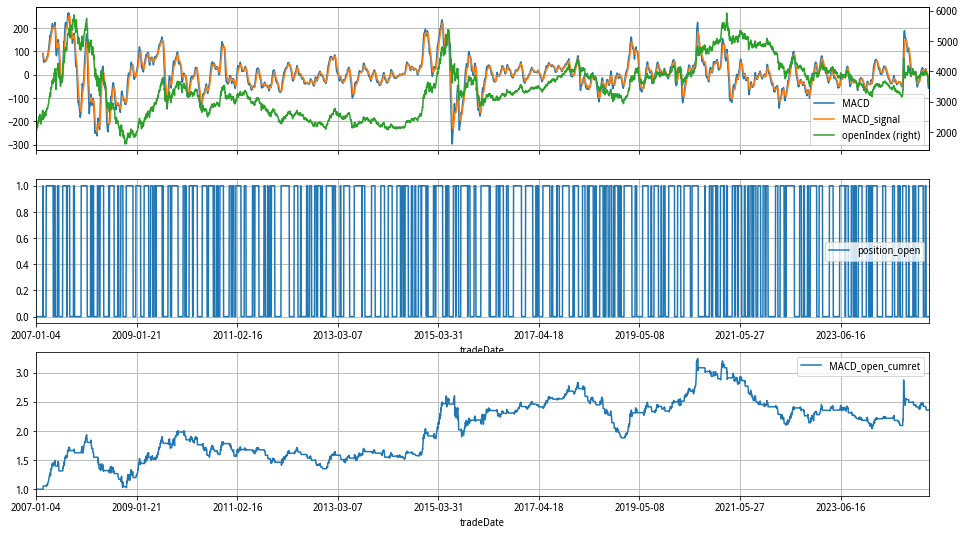

In [115]:
MACD_df['signal'] = 0
MACD_df.loc[MACD_df['MACD'] > MACD_df['MACD_signal'], 'signal'] = 1
MACD_df['open_ret'] = MACD_df['openIndex']/MACD_df['openIndex'].shift()-1
MACD_df['position_close'] = MACD_df['signal']
MACD_df['position_open'] = MACD_df['signal'].shift()
MACD_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
MACD_df['position_close_ret'] = MACD_df['position_close'].shift() * MACD_df['close_ret']
MACD_df['position_open_ret'] = MACD_df['position_open'].shift() * MACD_df['open_ret']
MACD_df['position_close_ret_demean'] = MACD_df['position_close'].shift() * MACD_df['close_ret_demean']
MACD_df['position_open_ret_demean'] = MACD_df['position_open'].shift() * MACD_df['open_ret_demean']
MACD_df['MACD_close_cumret'] = (MACD_df['position_close_ret']+1).cumprod()
MACD_df['MACD_open_cumret'] = (MACD_df['position_open_ret']+1).cumprod()
MACD_ret_df = MACD_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','MACD','MACD_signal',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                       'position_close_ret_demean','position_open_ret_demean',
                        'MACD_close_cumret','MACD_open_cumret']].copy()
MACD_ret_df.set_index('tradeDate',inplace=True)
# open price cumret
fig, axes = plt.subplots(3,1)
MACD_ret_df[['MACD','MACD_signal']].plot(ax=axes[0], grid=True)
MACD_ret_df[['openIndex']].plot(secondary_y=True,ax=axes[0],grid=True)
MACD_ret_df[['position_open']].plot(ax=axes[1], grid=True)
MACD_ret_df[['MACD_open_cumret']].plot(ax=axes[2], grid=True)

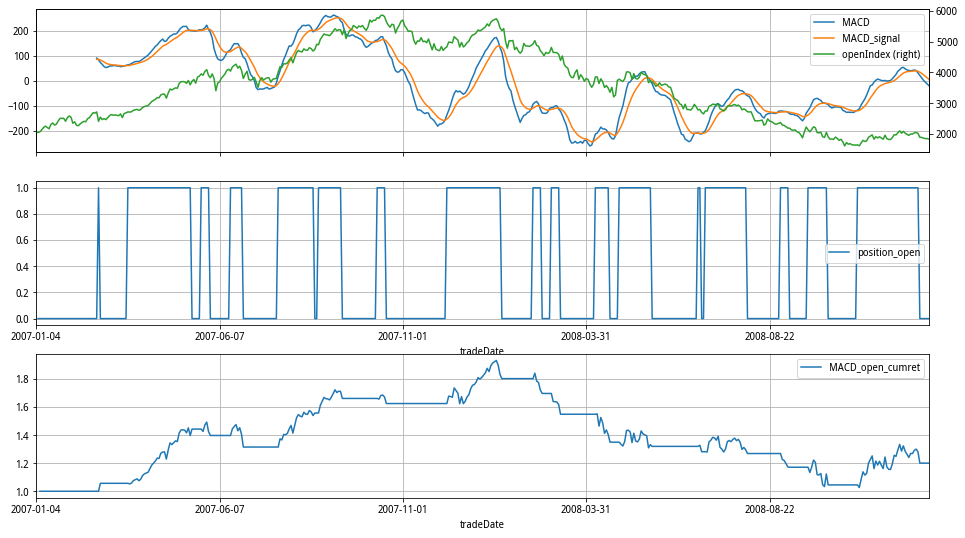

In [116]:
fig, axes = plt.subplots(3,1)
MACD_ret_df.loc[:'2009',['MACD','MACD_signal']].plot(ax=axes[0], grid=True)
MACD_ret_df.loc[:'2009',['openIndex']].plot(secondary_y=True,ax=axes[0],grid=True)
MACD_ret_df.loc[:'2009',['position_open']].plot(ax=axes[1], grid=True)
MACD_ret_df.loc[:'2009',['MACD_open_cumret']].plot(ax=axes[2], grid=True)

## Cross-sectional test

In [117]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,negMarketValue,turnoverValue,turnoverRate,EMA,open_ret,close_ret,signal
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,4.835036e+10,4.182345e+09,0.0840,NaN,NaN,0.197544,0
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,5.318694e+10,2.285485e+09,0.0440,NaN,-0.016970,0.100033,0
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,5.487665e+10,2.761567e+09,0.0510,NaN,0.097410,0.031769,0
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,5.456661e+10,2.324186e+09,0.0426,NaN,0.011516,-0.005650,0
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,4.994705e+10,2.446556e+09,0.0489,NaN,-0.120245,-0.084659,0
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,4.672266e+10,1.617434e+09,0.0336,NaN,-0.005682,-0.064557,0
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,4.266117e+10,1.410758e+09,0.0316,NaN,-0.053968,-0.086928,0
117,000001.XSHE,2007-07-02,870.870,867.073,848.402,4.247515e+10,8.756147e+08,0.0209,NaN,-0.100336,-0.004360,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13791153,689009.XSHG,2025-04-02,64.411,64.149,64.330,3.502029e+10,2.618055e+08,0.0075,62.681283,-0.021150,-0.004068,1


In [118]:
stk_df.drop('EMA',axis=1,inplace=True)

In [119]:
stk_df['MACD'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[0])
stk_df['MACD_signal'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[1])

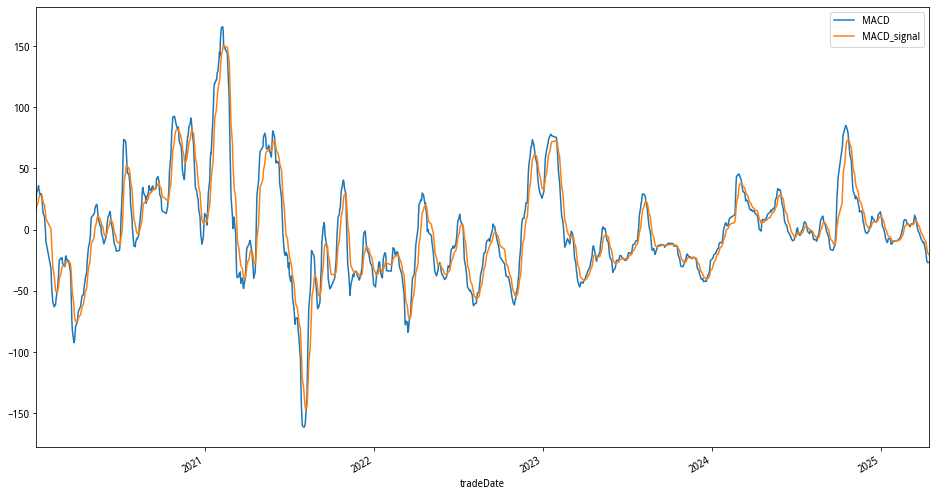

In [120]:
stk_df.loc[stk_df['secID']=='000001.XSHE',['tradeDate','MACD','MACD_signal']].set_index('tradeDate').loc['2020':].plot()

In [121]:
stk_df['signal'] = 0
stk_df.loc[stk_df['MACD'] > stk_df['MACD_signal'], 'signal'] = 1

In [122]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,negMarketValue,turnoverValue,turnoverRate,open_ret,close_ret,signal,MACD,MACD_signal
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,4.835036e+10,4.182345e+09,0.0840,NaN,0.197544,0,NaN,NaN
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,5.318694e+10,2.285485e+09,0.0440,-0.016970,0.100033,0,NaN,NaN
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,5.487665e+10,2.761567e+09,0.0510,0.097410,0.031769,0,NaN,NaN
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,5.456661e+10,2.324186e+09,0.0426,0.011516,-0.005650,0,NaN,NaN
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,4.994705e+10,2.446556e+09,0.0489,-0.120245,-0.084659,0,NaN,NaN
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,4.672266e+10,1.617434e+09,0.0336,-0.005682,-0.064557,0,NaN,NaN
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,4.266117e+10,1.410758e+09,0.0316,-0.053968,-0.086928,0,NaN,NaN
117,000001.XSHE,2007-07-02,870.870,867.073,848.402,4.247515e+10,8.756147e+08,0.0209,-0.100336,-0.004360,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13791153,689009.XSHG,2025-04-02,64.411,64.149,64.330,3.502029e+10,2.618055e+08,0.0075,-0.021150,-0.004068,0,2.003560,2.162453


In [123]:
%%time
rule_ret_df = stk_df.groupby('secID').apply(rule_return)

CPU times: user 58.6 s, sys: 1.08 s, total: 59.7 s
Wall time: 59.7 s


In [124]:
rule_ret_df.reset_index(inplace=True)

In [125]:
rule_ret_df.drop('level_1',axis=1,inplace=True)

In [126]:
rule_ret_df

,secID,tradeDate,position_open_ret_demean,open_cumret
0,000001.XSHE,2007-06-20,NaN,NaN
1,000001.XSHE,2007-06-21,NaN,NaN
2,000001.XSHE,2007-06-22,0.000000,1.000000
3,000001.XSHE,2007-06-25,0.000000,1.000000
4,000001.XSHE,2007-06-27,-0.000000,1.000000
5,000001.XSHE,2007-06-28,-0.000000,1.000000
6,000001.XSHE,2007-06-29,-0.000000,1.000000
7,000001.XSHE,2007-07-02,-0.000000,1.000000
...,...,...,...,...
12825314,689009.XSHG,2025-04-02,-0.022381,0.812724


### Cross-sectional test of cumulative return

In [127]:
rule_cumret_by_crs = rule_ret_df.groupby('secID')['open_cumret'].last()

In [128]:
rule_cumret_by_crs

secID
000001.XSHE     1.225408
000002.XSHE     3.601465
000004.XSHE     3.962834
000005.XSHE     2.925598
000006.XSHE    11.867153
000007.XSHE     2.306936
000008.XSHE     3.223468
000009.XSHE    15.067728
                 ...    
688789.XSHG     0.619252
688793.XSHG     0.345806
688798.XSHG     0.522928
688799.XSHG     0.625999
688800.XSHG     0.475991
688819.XSHG     0.875406
688981.XSHG     1.286059
689009.XSHG     0.812724
Name: open_cumret, Length: 5378, dtype: float64

In [129]:
rule_cumret_by_crs.describe()

count    5377.000000
mean        2.151832
std         3.391175
min         0.008941
25%         0.721650
50%         1.165039
75%         2.239367
max        78.218373
Name: open_cumret, dtype: float64

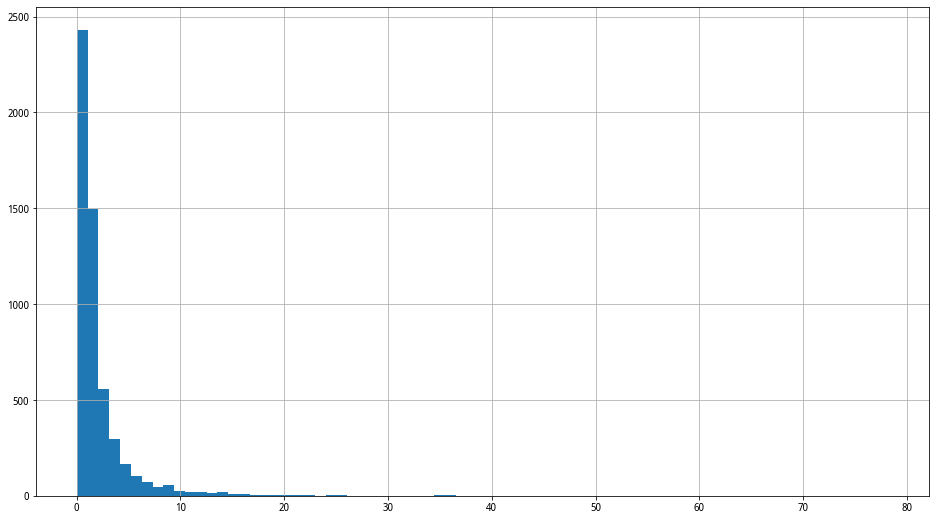

In [130]:
rule_cumret_by_crs.hist(bins=75)

In [131]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y-const, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_cumret'])

,rule_cumret
ret_mean,1.151832
t_values,24.908607


In [132]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit()
print(reg.t_test('const = 1'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             2.1518      0.046     24.906      0.000       2.061       2.242


平均年化收益：

In [133]:
# 2.1293**(1/(2022-2007+1))-1

In [134]:
1.9272**(1/(2023-2007+1)) - 1

0.03934659891056258

In [135]:
2.1518**(1/(2024-2007+1)) - 1

0.04349168945680271

### Cross-sectional test of mean daily return

In [136]:
# time-series mean of daily return
rule_tsmean_ret_by_crs = rule_ret_df.groupby('secID')['position_open_ret_demean'].mean()
rule_tsmean_ret_by_crs

secID
000001.XSHE   -0.000014
000002.XSHE    0.000244
000004.XSHE    0.000555
000005.XSHE    0.000507
000006.XSHE    0.000430
000007.XSHE    0.000137
000008.XSHE    0.000179
000009.XSHE    0.000605
                 ...   
688789.XSHG   -0.000489
688793.XSHG   -0.000432
688798.XSHG   -0.000236
688799.XSHG   -0.000248
688800.XSHG   -0.000782
688819.XSHG    0.000382
688981.XSHG    0.000280
689009.XSHG   -0.000486
Name: position_open_ret_demean, Length: 5378, dtype: float64

In [137]:
rule_tsmean_ret_by_crs.dropna(inplace=True)
y = rule_tsmean_ret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]

In [138]:
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_daily_ret'])

,rule_daily_ret
ret_mean,0.000045
t_values,5.911285


## Time series test. Bootstrapping: White's Reality Check

- 原始index return去掉均值的目的：过滤掉牛市或者熊市时，随机策略的正或负的收益的偏误
- position return 去掉均值的目的：bootstrap 的原假设是：策略期望收益是0。以此生成抽样分布。

In [139]:
rule_ret_series = MACD_ret_df['position_open_ret_demean'].dropna() # position_open_ret_demean: (raw return demeaned)*position
rule_ret_series_for_bootstrap = rule_ret_series - rule_ret_series.mean() # demean here: H0: the average of the rule's return is zero
n_sample = rule_ret_series.shape[0]
n_boostrap = 1000

In [140]:
n_sample

4439

In [141]:
rule_ret_series.mean()

0.00011411955588453497

In [142]:
rule_ret_mean_distr = []
for i in range(n_boostrap):
    rule_ret_mean_distr.append(np.random.choice(rule_ret_series_for_bootstrap, n_sample).mean())

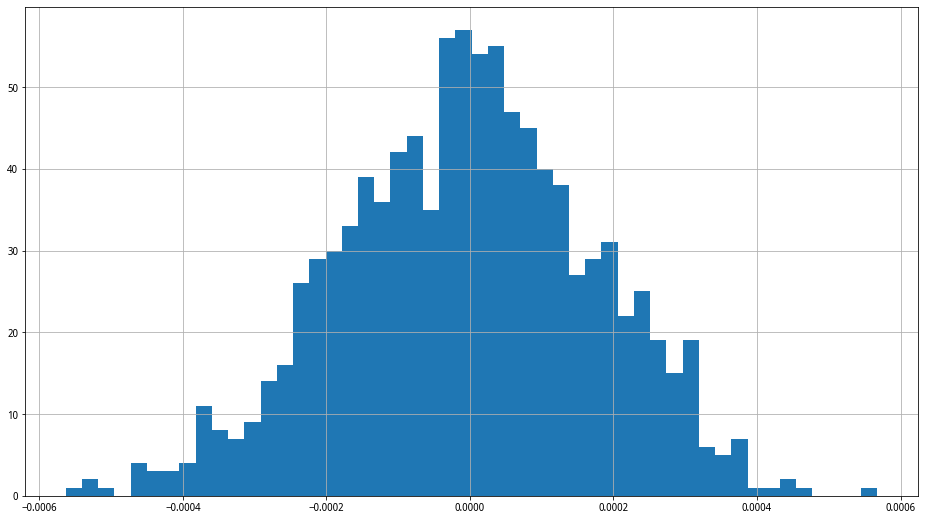

In [143]:
rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
rule_ret_mean_distr.hist(bins=50)

In [144]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum() / n_boostrap

0.252

In [145]:
np.mean(rule_ret_series)

0.00011411955588453497

In [146]:
def white_reality_test(rule_ret, n_boostrap=1000):
    n_sample = len(rule_ret)
    if n_sample < 100:
        return None
    else:
        mean_rule_ret = np.mean(rule_ret)
        rule_ret_for_bootstrap = rule_ret - mean_rule_ret
        rule_ret_mean_distr = []
        for i in range(n_boostrap):
            rule_ret_mean_distr.append(np.random.choice(rule_ret_for_bootstrap, n_sample).mean())
        rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
        pvalue = (rule_ret_mean_distr > mean_rule_ret).sum() / n_boostrap
        return pvalue

In [147]:
# The p value of the rule's return series
white_reality_test(rule_ret_series)

0.247

Compare this when there are multiple strategies

#### Test another stock

In [148]:
one_stk_id = np.random.choice(rule_ret_df['secID'].unique(),1)[0]

In [149]:
rule_ret_series = rule_ret_df.loc[rule_ret_df['secID'] == one_stk_id,'position_open_ret_demean']

In [150]:
rule_ret_series.dropna(inplace=True)

In [151]:
white_reality_test(rule_ret_series)

0.606

#### Test 300 stocks

In [152]:
stk_id_300 = np.random.choice(rule_ret_df['secID'].unique(),300,replace=False)

In [153]:
temp = rule_ret_df.loc[rule_ret_df['secID'].isin(stk_id_300)].copy()

In [154]:
temp.dropna(inplace=True)

In [155]:
temp

,secID,tradeDate,position_open_ret_demean,open_cumret
4247,000002.XSHE,2007-01-08,-0.0,1.000000
4248,000002.XSHE,2007-01-09,0.0,1.000000
4249,000002.XSHE,2007-01-10,0.0,1.000000
4250,000002.XSHE,2007-01-11,0.0,1.000000
4251,000002.XSHE,2007-01-12,-0.0,1.000000
4252,000002.XSHE,2007-01-15,-0.0,1.000000
4253,000002.XSHE,2007-01-16,0.0,1.000000
4254,000002.XSHE,2007-01-17,0.0,1.000000
...,...,...,...,...
12816457,688787.XSHG,2025-04-02,0.0,0.869381


In [156]:
%%time
stk_white_p = temp.groupby('secID')['position_open_ret_demean'].apply(white_reality_test)

CPU times: user 47.1 s, sys: 0 ns, total: 47.1 s
Wall time: 47.1 s


In [157]:
stk_white_p

secID
000002.XSHE    0.196
000006.XSHE    0.145
000029.XSHE    0.576
000049.XSHE    0.480
000078.XSHE    0.434
000417.XSHE    0.600
000418.XSHE    0.407
000430.XSHE    0.326
               ...  
688610.XSHG    0.125
688611.XSHG    0.351
688656.XSHG    0.208
688662.XSHG    0.289
688689.XSHG    0.113
688776.XSHG    0.368
688777.XSHG    0.537
688787.XSHG    0.476
Name: position_open_ret_demean, Length: 300, dtype: float64

In [158]:
stk_white_p.describe()

count    297.000000
mean       0.450700
std        0.221145
min        0.023000
25%        0.291000
50%        0.432000
75%        0.610000
max        0.995000
Name: position_open_ret_demean, dtype: float64

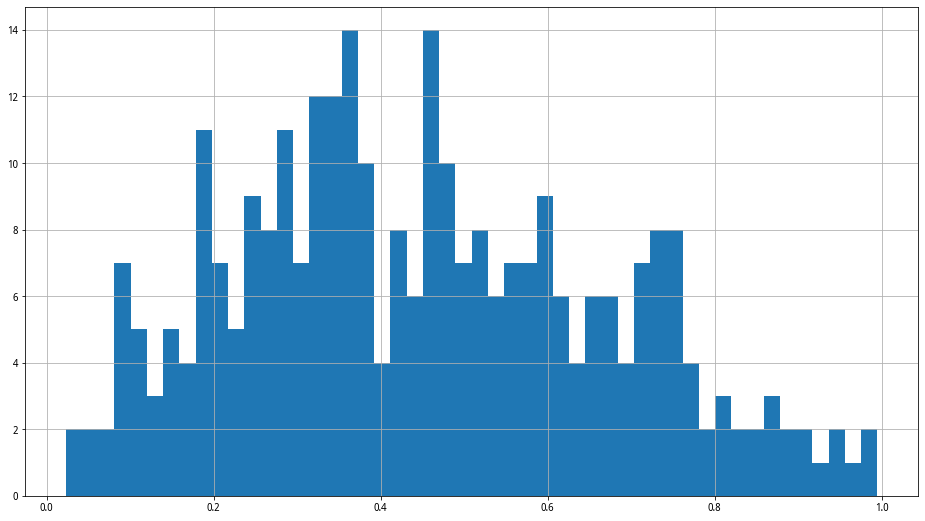

In [159]:
stk_white_p.hist(bins=50)

In [160]:
stk_white_p.loc[stk_white_p < 0.10]

secID
002253.XSHE    0.082
002547.XSHE    0.095
002675.XSHE    0.056
300216.XSHE    0.031
301060.XSHE    0.094
600318.XSHG    0.023
600392.XSHG    0.086
600536.XSHG    0.047
600773.XSHG    0.086
601866.XSHG    0.068
603081.XSHG    0.089
688038.XSHG    0.094
688316.XSHG    0.067
Name: position_open_ret_demean, dtype: float64

In [161]:
good_MACD_stks = stk_white_p.loc[stk_white_p < 0.10].index

In [162]:
rule_ret_df.loc[rule_ret_df['secID']=='600146.XSHG','open_cumret']

7804676         NaN
7804677         NaN
7804678    1.000000
7804679    1.000000
7804680    1.000000
7804681    1.000000
7804682    1.000000
7804683    1.000000
             ...   
7807107    0.228394
7807108    0.228394
7807109    0.228394
7807110    0.228394
7807111    0.228394
7807112    0.228394
7807113    0.219027
7807114    0.219027
Name: open_cumret, Length: 2439, dtype: float64

In [163]:
rule_ret_df.loc[rule_ret_df['secID'].isin(good_MACD_stks[0:5])].set_index('tradeDate',inplace=True)

In [164]:
temp2 = rule_ret_df.loc[rule_ret_df['secID'].isin(good_MACD_stks)].copy()

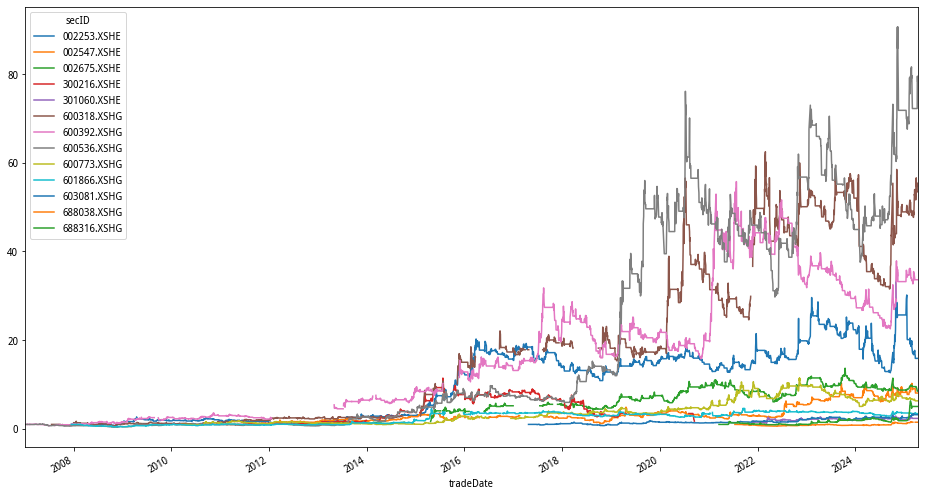

In [165]:
temp2.pivot(index='tradeDate',columns='secID',values='open_cumret').plot()

# White's Reality Check for multiple strategies

In [166]:
def rule_return_open(df, demean=True):
    """
    df should contain these columns:
        signal: the signal generated by the rule
        close_ret: return calculated by close price
        open_ret: return calculated by open price
    close_ret_demean is demeaned return of close_ret, i.e. close_ret - close_ret.mean.
    open_ret_demean is similarly defined. The use of demeaned return series is to adjust the
    bias created by bullish or bearish markets.
    """
    df['position_open'] = df['signal'].shift()
    df['position_open_ret'] = df['position_open'].shift() * df['open_ret']
    df['position_open_ret_demean'] = df['position_open'].shift() * df['open_ret_demean']
    if demean==True:
        return df['position_open_ret_demean']
    else:
        return df['position_open_ret']

In [167]:
cols = ['tradeDate','openIndex','closeIndex','open_ret','close_ret','open_ret_demean','close_ret_demean']
ta_rules_df = hs300_df[cols].copy()

In [168]:
# MA
ma_params = [30, 20, 10]
for ma_param in ma_params:
    ta_rules_df[f'MA{ma_param}'] = ta.SMA(ta_rules_df['closeIndex'], ma_param)
    ta_rules_df['signal'] = np.nan
    ta_rules_df.loc[ta_rules_df['closeIndex'] > ta_rules_df[f'MA{ma_param}'], 'signal'] = 1
    ta_rules_df.loc[ta_rules_df['closeIndex'] < ta_rules_df[f'MA{ma_param}'], 'signal'] = 0
    ta_rules_df[f'ret_MA{ma_param}'] = rule_return_open(ta_rules_df)
    
ta_rules_df = ta_rules_df[cols+[f'ret_MA{ma_param}' for ma_param in ma_params]].copy()

In [169]:
ta_rules_df

,tradeDate,openIndex,closeIndex,open_ret,close_ret,open_ret_demean,close_ret_demean,ret_MA30,ret_MA20,ret_MA10
0,2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0.012487,NaN,NaN,NaN
1,2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,-0.010952,0.002530,NaN,NaN,NaN
2,2007-01-08,2072.0000,2131.5600,0.010165,0.028308,0.009872,0.028037,NaN,NaN,NaN
3,2007-01-09,2137.4900,2200.0900,0.031607,0.032150,0.031314,0.031879,NaN,NaN,NaN
4,2007-01-10,2210.7600,2255.9700,0.034279,0.025399,0.033986,0.025128,NaN,NaN,NaN
5,2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,0.020628,-0.011060,NaN,NaN,NaN
6,2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,-0.018525,-0.026207,NaN,NaN,NaN
7,2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,-0.020565,0.051984,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4433,2025-04-02,3884.4181,3884.3858,-0.002148,-0.000848,-0.002441,-0.001119,-0.0,-0.0,-0.0


In [170]:
cols = ta_rules_df.columns.tolist()

In [171]:
#EMA
ema_params = [30, 20, 10]
for ema_param in ema_params:
    ta_rules_df[f'EMA{ema_param}'] = ta.EMA(ta_rules_df['closeIndex'], ema_param)
    ta_rules_df['signal'] = np.nan
    ta_rules_df.loc[ta_rules_df['closeIndex'] > ta_rules_df[f'EMA{ema_param}'], 'signal'] = 1
    ta_rules_df.loc[ta_rules_df['closeIndex'] < ta_rules_df[f'EMA{ema_param}'], 'signal'] = 0
    ta_rules_df[f'ret_EMA{ema_param}'] = rule_return_open(ta_rules_df)
    
ta_rules_df = ta_rules_df[cols+[f'ret_EMA{ema_param}' for ema_param in ema_params]].copy()

In [172]:
ta_rules_df

,tradeDate,openIndex,closeIndex,open_ret,close_ret,open_ret_demean,close_ret_demean,ret_MA30,ret_MA20,ret_MA10,ret_EMA30,ret_EMA20,ret_EMA10
0,2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0.012487,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,-0.010952,0.002530,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-01-08,2072.0000,2131.5600,0.010165,0.028308,0.009872,0.028037,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-01-09,2137.4900,2200.0900,0.031607,0.032150,0.031314,0.031879,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-01-10,2210.7600,2255.9700,0.034279,0.025399,0.033986,0.025128,NaN,NaN,NaN,NaN,NaN,NaN
5,2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,0.020628,-0.011060,NaN,NaN,NaN,NaN,NaN,NaN
6,2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,-0.018525,-0.026207,NaN,NaN,NaN,NaN,NaN,NaN
7,2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,-0.020565,0.051984,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4433,2025-04-02,3884.4181,3884.3858,-0.002148,-0.000848,-0.002441,-0.001119,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [173]:
cols = ta_rules_df.columns.tolist()

In [174]:
# MACD
macd_models = {'MACD1': {'fastperiod':12, 'slowperiod':26, 'signalperiod':9},
               'MACD2': {'fastperiod':10, 'slowperiod':20, 'signalperiod':5}}
for macd, param in macd_models.items():
    ta_rules_df[macd], ta_rules_df[f'{macd}_signal'], _ = ta.MACD(ta_rules_df['closeIndex'], fastperiod=param['fastperiod'], slowperiod=param['slowperiod'], signalperiod=param['signalperiod'])
    ta_rules_df['signal'] = 0
    ta_rules_df.loc[ta_rules_df[macd] > ta_rules_df[f'{macd}_signal'], 'signal'] = 1
    ta_rules_df[f'ret_{macd}'] = rule_return_open(ta_rules_df)

In [175]:
ta_rules_df.dropna(inplace=True)
ta_rules_df.reset_index(inplace=True,drop=True)

In [176]:
ta_rules_df

,tradeDate,openIndex,closeIndex,open_ret,close_ret,open_ret_demean,close_ret_demean,ret_MA30,ret_MA20,ret_MA10,...,MACD1,MACD1_signal,signal,position_open,position_open_ret,position_open_ret_demean,ret_MACD1,MACD2,MACD2_signal,ret_MACD2
0,2007-02-27,2717.8100,2457.4900,0.014385,-0.092400,0.014092,-0.092671,0.014092,0.014092,0.014092,...,90.911597,86.028313,0,1.0,0.014385,0.014092,0.000000,71.690413,73.792501,0.014092
1,2007-02-28,2413.4200,2544.5700,-0.111998,0.035435,-0.112291,0.035164,-0.112291,-0.112291,-0.112291,...,84.683369,85.759325,0,0.0,-0.111998,-0.112291,-0.000000,65.064530,70.883178,-0.112291
2,2007-03-01,2550.2600,2473.5400,0.056700,-0.027914,0.056407,-0.028185,0.056407,0.000000,0.000000,...,73.172441,83.241948,0,0.0,0.000000,0.000000,0.056407,52.883214,64.883190,0.000000
3,2007-03-02,2468.6700,2508.7300,-0.031993,0.014227,-0.032286,0.013956,-0.032286,-0.032286,-0.000000,...,66.127212,79.819001,0,0.0,-0.000000,-0.000000,-0.000000,45.996903,58.587761,-0.000000
4,2007-03-05,2503.8200,2475.6100,0.014238,-0.013202,0.013946,-0.013473,0.013946,0.000000,0.000000,...,57.211809,75.297562,0,0.0,0.000000,0.000000,0.000000,37.235228,51.470250,0.000000
5,2007-03-06,2467.7400,2520.2900,-0.014410,0.018048,-0.014703,0.017777,-0.014703,-0.014703,-0.000000,...,53.139036,70.865857,0,0.0,-0.000000,-0.000000,-0.000000,33.972945,45.637815,-0.000000
6,2007-03-07,2532.9800,2589.4400,0.026437,0.027437,0.026144,0.027166,0.026144,0.026144,0.000000,...,54.858783,67.664442,0,0.0,0.000000,0.000000,0.000000,36.956746,42.744125,0.000000
7,2007-03-08,2597.7200,2627.6300,0.025559,0.014748,0.025266,0.014477,0.025266,0.025266,0.000000,...,58.627488,65.857051,0,0.0,0.000000,0.000000,0.000000,41.832083,42.440111,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4400,2025-04-02,3884.4181,3884.3858,-0.002148,-0.000848,-0.002441,-0.001119,-0.000000,-0.000000,-0.000000,...,-6.313510,4.661848,0,0.0,-0.000000,-0.000000,-0.000000,-10.349869,-4.559335,-0.000000


In [177]:
multi_rule_cols = ta_rules_df.columns[ta_rules_df.columns.str.startswith('ret')]

multi_rule_ret_df = ta_rules_df[multi_rule_cols].copy()

multi_rule_ret_df

,ret_MA30,ret_MA20,ret_MA10,ret_EMA30,ret_EMA20,ret_EMA10,ret_MACD1,ret_MACD2
0,0.014092,0.014092,0.014092,0.014092,0.014092,0.014092,0.000000,0.014092
1,-0.112291,-0.112291,-0.112291,-0.112291,-0.112291,-0.112291,-0.000000,-0.112291
2,0.056407,0.000000,0.000000,0.056407,0.000000,0.000000,0.056407,0.000000
3,-0.032286,-0.032286,-0.000000,-0.032286,-0.032286,-0.032286,-0.000000,-0.000000
4,0.013946,0.000000,0.000000,0.013946,0.000000,0.000000,0.000000,0.000000
5,-0.014703,-0.014703,-0.000000,-0.014703,-0.014703,-0.000000,-0.000000,-0.000000
6,0.026144,0.026144,0.000000,0.026144,0.000000,0.000000,0.000000,0.000000
7,0.025266,0.025266,0.000000,0.025266,0.025266,0.025266,0.000000,0.000000
...,...,...,...,...,...,...,...,...
4400,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


In [178]:
def multi_white_reality_test(target_rule, multi_rule_ret_df, n_bootstrap=500):
    """
    target_rule: the name of the rule under consideration. target_rule should be one column of multi_rule_ret_df.
    multi_rule_ret_df: the df of multiple rule returns.
    """
    n_sample = multi_rule_ret_df.shape[0]
    if n_sample < 100:
        return None
    else:   
        max_bs_distr = np.full(shape=n_bootstrap, fill_value=np.nan)
        multi_rule_ret_df_mean = multi_rule_ret_df - multi_rule_ret_df.mean()
        for i in tqdm(range(n_bootstrap)):
            idx = np.random.choice(multi_rule_ret_df.index, n_sample)
            max_bs_distr[i] = multi_rule_ret_df_mean.loc[idx].mean().max()
        pvalue = (max_bs_distr > multi_rule_ret_df[target_rule].mean()).sum() / n_bootstrap
        return pvalue, max_bs_distr

In [179]:
p_MACD1, max_bs_distr_MACD1 = multi_white_reality_test(target_rule='ret_MACD1', multi_rule_ret_df=multi_rule_ret_df)

100%|██████████| 500/500 [00:00<00:00, 715.95it/s]


In [180]:
p_MACD1

0.478

Compare this with the WRC when there is only one 